In [1]:
import math
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
NUM_STEPS = 50
SHAPE = (1, 3, 32, 32)
LATENT_SHAPE = (1, 2, 3)
def noise(x, beta):
    x = x * torch.normal(mean=sqrt_beta)
def generate_random_noise():
    return torch.normal(mean=0., std=torch.ones(SHAPE))
def create_betas():
    beta = 1
    betas = []
    for i in range(NUM_STEPS):
        betas.append(beta / NUM_STEPS)
    return betas
# reverse process:
class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.mu = nn.Parameter(torch.tensor(LATENT_SHAPE, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.tensor(LATENT_SHAPE, dtype=torch.float64))
    # forward process
    def _forward():
        x = generate_random_noise()
        betas = create_betas()
        for i in range(NUM_STEPS - 1):
            beta = betas[i]
            sqrt_beta = math.sqrt(1 - beta)
            x *= torch.normal(mean=sqrt_beta*x, std=beta, shape=SHAPE)
        return x
    def _reverse(x): 
        mu = torch.Parameter(shape=LATENT_SHAPE)
        sigma = torch.Parameter(shape=LATENT_SHAPE)
        for i in range(NUM_STEPS):
            x *= torch.normal(mean=mu, std=sigma, shape=SHAPE)
        return x
    def forward(x):
        return x

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.input_shape = (1, 3, 32, 32)
        self.output_shape = (1, 3, 32, 32)

        self.conv1 = torch.nn.Conv2d(3, 3, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(3, 3, 3, padding=1)
    
    def forward(self, x, t):
        # later: use attn to condition on the timestep
        # the conditioning can also be on other stuff, like a text prompt
        print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        
        return x

In [4]:
# HELPER FUNCTIONS

def remove_labels(ds):
    return list(map(lambda x: x[0], ds))

def totensor_ds(ds):
    t = transforms.ToTensor()
    return list(map(lambda x: t(x), ds))

def make_diffusion_dataset(ds):
    im = []
    t = torchvision.transforms.ToTensor()
    for img, label in ds:
        im.append(t(img))
    im = im[:10]
    for i, img in enumerate(im):
        noise_list = noise(img)
        im[i] = [img]
        #[im[i].append(a) for a in noise_list]
    return im

# perform a sequence of noising steps on an image. Then, generalize it to n noising steps (Apply combined product)
def noise(img):
    beta = 0.4
    sqrt_beta = math.sqrt(1 - beta)
    img = img * torch.normal(img * sqrt_beta, beta)
    return img

# noise an image for n steps
def noise_n_steps(img, betas, n):
    img = torch.clone(img)
    
    for b, i in zip(betas, range(n)):
        beta = b
        sqrt_beta = (1 - beta) ** 0.5
        img *= torch.normal(img * sqrt_beta, beta) #torch.ones(img.shape) * sqrt_beta, beta)
    return img

# noise an image for 1 step, given beta
def noise_1_step(img, beta):
    sqrt_beta = math.sqrt(1 - beta)
    img *= torch.normal(torch.ones(img.shape) * sqrt_beta, beta)
    
# closed form sampling for the noise using alpha param
def noise_nth_step(img, betas, t):
    alphas_cumprod = 1
    for i in range(t):
        alpha = 1 - betas[i]
        alphas_cumprod *= alpha
    return torch.normal(img * math.sqrt(alphas_cumprod), 1 - alphas_cumprod)

def noise_alpha(img, betas, t):
    alpha = torch.prod(1 - betas[:t])
    return torch.normal(img * (alpha ** 0.5), (1 - alpha))

# single loss update using KL divergence
# KL is the distance between probability of distributions p and q 
def loss_update(q_t0, p_xt, p_01):
    return

# calculate alpha at a certain timestep t
def calculate_alpha(betas, t):
    print(t)
    return torch.prod(1 - betas[:t])

def linear_beta_schedule(num_timesteps):
    scale = 1000 / num_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float64)

def fake_normalize(t: torch.Tensor):
    return (t - torch.mean(t)) / torch.var(t)

In [5]:
class EpsModel():
    def __init__(self):
        pass
    
class DiffusionTrainer():
    def __init__(self):
        pass

In [6]:
class DiffusionModel():
    
    def __init__(self, eps_model, epochs=10, train_steps_per_epoch=-1):
        
        self.epochs = epochs
        self.train_steps = train_steps_per_epoch # -1 just means don't interrupt
        self.cum_loss = []
        self.eps_model = eps_model
        
        if beta_schedule is not None:
            self.beta_schedule = beta_schedule
        else:
            self.beta_schedule = linear_beta_schedule
    
    def log(self, loss):
        self.cum_loss.append(n_iter, n_epoch, loss.numel())
        
    def calculate_loss(self, x_start, t):
        # apparently the noise isnt scaled or anything
        noise = torch.randn_like(x_start)
        
    # TRAINING LOOP
    def _train(dataset, eps_model, epochs=10, train_steps_per_epoch=-1):    
        img_shape = (1, 3, 32, 32)
        epochs = 10
        betas = linear_beta_schedule(n_noise_steps)
        optim = torch.optim.Adam(eps_model.parameters()) # we leave default params
        loss_fn = torch.nn.MSELoss()

        for epoch in range(epochs):
            for i, img in enumerate(dataset):

                if train_steps_per_epoch != -1:
                    if i == train_steps_per_epoch:
                        return 

                t = torch.randint(0, NUM_STEPS, (1,))[0]
                x_0 = img
                alpha = calculate_alpha(betas, t)
                eps = torch.randn_like(img)
                #eps = torch.normal(torch.zeros(img_shape), 1)
                loss = loss_fn(eps, eps_model(x_0, t)) 
                
                loss.backward()
                optim.step()

    def _sample(self, eps_model, num_steps=50):
        img_shape = (1, 3, 32, 32)
        betas = linear_beta_schedule(n_noise_steps)
        x = torch.normal(torch.zeros(img_shape), 1)
        for t in range(0, num_steps, -1):
            sig = alpha ** 2
            x = (1 / alpha) * (x - ((1 - alpha) / ((1 - alpha) ** 2)) * eps_model(x, t))

        return x

In [7]:
ds = torchvision.datasets.CIFAR10(download=True, root=".")
diffusion_ds = remove_labels(ds)
diffusion_ds = totensor_ds(diffusion_ds)

Files already downloaded and verified


In [247]:
eps_model = UNet()
diffusion = DiffusionModel()
diffusion._sample(eps_model)
#diffusion_sample(eps_model)
#diffusion_train(diffusion_ds, eps_model, epochs=1, train_steps_per_epoch=10)

TypeError: __init__() missing 1 required positional argument: 'eps_model'

In [8]:
"""
Some notes from lucidrains impl

"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


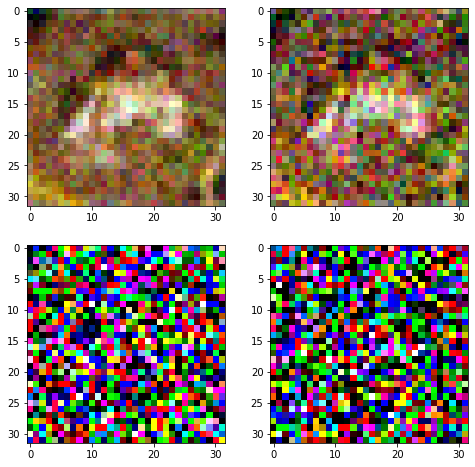

In [9]:
t = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0,0,0],[1,1,1])])

n_noise_steps = 50
im = t(ds[0][0])

betas = linear_beta_schedule(n_noise_steps)

im_15 = noise_alpha(im, betas=betas, t=5)
im_30 = noise_alpha(im, betas=betas, t=7)
im_45 = noise_alpha(im, betas=betas, t=30)
im_50 = noise_alpha(im, betas=betas, t=45)

f, arr = plt.subplots(2, 2, figsize=(8, 8))
arr[0,0].imshow(im_15.permute(1, 2, 0))
arr[0,1].imshow(im_30.permute(1, 2, 0))
arr[1,0].imshow(im_45.permute(1, 2, 0))
arr[1,1].imshow(im_50.permute(1, 2, 0))

In [ ]:
# p_q array, p_theta array, p_xt last in t
def loss_function(p_xt, p_theta, q):
    return -log(p_xt) - torch.sum(p_theta / p_q)

def training_loop_iter(model, img, t):
    noised_img = apply_noise(img, t)
    denoised = model(img).squeeze(0)
    loss(denoised, img)
    return